In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score 

%matplotlib inline


In [132]:
RANDOM_SEED = 42
!pip freeze > requirements.txt


In [133]:
df_train = pd.read_csv('https://raw.githubusercontent.com/DShev1982/skillfactory/master/data%20for%20projects/mod5_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/DShev1982/skillfactory/master/data%20for%20projects/mod5_test.csv')


In [134]:
def first_look(df,col):
    print('Столбец', col)
    print('Распределение признака:')
    display(df[col].describe())
    fig, ax = plt.subplots()
    IQR = 1.5*(df[col].describe()['75%']-df[col].describe()['25%'])
    ll = df[col].describe()['25%'] - IQR
    hl = df[col].describe()['75%'] + IQR
    out_ll = df[df[col] < ll][col].count()
    out_hl = df[df[col] > hl][col].count()
    count = df[col].describe()['count']
    out_ll_p = round(out_ll/count,2)
    out_hl_p = round(out_hl/count,2)
    print('нижняя квартильная граница: {}\nверхняя квартильная граница: {}\nкол-во записей за нижней квартильной границей: {}\nотносительное кол-во записей за нижней квартильной границей: {}\nкол-во записей за верхней квартильной границей: {}\nотносительное кол-во записей за верхней квартильной границей: {}'.format(ll,hl,out_ll,out_ll_p,out_hl,out_hl_p))
    df.loc[:,col].hist(ax=ax)
    ax.set_xlabel(col)
    ax.set_ylabel('count')
    plt.show()
    sns.boxplot(data = df[col])
    plt.show()

In [262]:
def all_metrics(y_true, y_pred, y_pred_prob):
    """Функция выводит в виде датафрейма значения основных метрик классификации"""
    dict_metric = {}
    P = np.sum(y_true==1)
    N = np.sum(y_true==0)
    TP = np.sum((y_true==1)&(y_pred==1))
    TN = np.sum((y_true==0)&(y_pred==0))
    FP = np.sum((y_true==0)&(y_pred==1))
    FN = np.sum((y_true==1)&(y_pred==0))
    
    dict_metric['P'] = [P,'Дефолт']
    dict_metric['N'] = [N,'БЕЗ дефолта']
    dict_metric['TP'] = [TP,'Истинно дефолтные']
    dict_metric['TN'] = [TN,'Истинно НЕ дефолтные']
    dict_metric['FP'] = [FP,'Ложно дефолтные']
    dict_metric['FN'] = [FN,'Ложно НЕ дефолтные']
    dict_metric['Accuracy'] = [accuracy_score(y_true, y_pred),'Accuracy=(TP+TN)/(P+N)']
    dict_metric['Precision'] = [precision_score(y_true, y_pred),'Точность = TP/(TP+FP)'] 
    dict_metric['Recall'] = [recall_score(y_true, y_pred),'Полнота = TP/P']
    dict_metric['F1-score'] = [f1_score(y_true, y_pred),'Среднее гармоническое Precision и Recall']
    dict_metric['ROC_AUC'] = [roc_auc_score(y_true, y_pred_prob),'ROC-AUC']    

    temp_df = pd.DataFrame.from_dict(dict_metric, orient='index', columns=['Значение', 'Описание метрики'])
    display(temp_df)    

In [267]:
def show_roc_curve(y_true, y_pred_prob):
    """Функция отображает ROC-кривую"""
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    plt.figure()
    plt.plot([0, 1], label='Случайный классификатор', linestyle='--')
    plt.plot(fpr, tpr, label = 'Логистическая регрессия')
    plt.title('Логистическая регрессия ROC AUC = %0.3f' % roc_auc_score(y_true, y_pred_prob))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

In [268]:
def show_confusion_matrix(y_true, y_pred):
    """Функция отображает confusion-матрицу"""
    color_text = plt.get_cmap('PuBu')(0.95)
    class_names = ['Дефолтный', 'НЕ дефолтный']
    cm = confusion_matrix(y_true, y_pred)
    cm[0,0], cm[1,1] = cm[1,1], cm[0,0]
    df = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), title="Матрица ошибок")
    ax.title.set_fontsize(15)
    sns.heatmap(df, square=True, annot=True, fmt="d", linewidths=1, cmap="PuBu")
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor", fontsize=12)
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor", fontsize=12)
    ax.set_ylabel('Предсказанные значения', fontsize=14, color = color_text)
    ax.set_xlabel('Реальные значения', fontsize=14, color = color_text)
    b, t = plt.ylim()
    plt.ylim(b+0.5, t-0.5)
    fig.tight_layout()
    plt.show()

In [135]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [136]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [387]:
# чтобы получить как можно больше информации по параметрам, 
# объединим train и test в один dataset

df_train['Train'] = 1 # помечаем где у нас трейн
df_test['Train'] = 0 # помечаем где у нас тест

df = df_train.append(df_test, sort=False).reset_index(drop=True) 

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [139]:
df.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default,Train
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,73799.000000,110148.000000
mean,55074.500000,39.249410,0.273205,0.165514,-1.904535,2.005002,56.751189,1.574945,2.497867,41012.648537,1.731588,2.765570,0.126994,0.669999
std,31797.133063,11.518063,0.799099,0.371645,0.499397,2.266926,13.065923,0.527562,0.687651,45399.735051,1.122652,1.010151,0.332968,0.470215
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000,0.000000
25%,27537.750000,30.000000,0.000000,0.000000,-2.260434,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000,0.000000
50%,55074.500000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000,1.000000
75%,82611.250000,48.000000,0.000000,0.000000,-1.567888,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000,1.000000
max,110148.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000,1.000000


In [140]:
df.sample(10)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train
51466,61322,11MAR2014,SCH,F,31,N,N,0,0,-2.209717,0,40,1,1,15000,1,3,N,0.0,1
64677,77226,25MAR2014,SCH,F,64,N,N,0,0,-2.367540,0,40,2,3,13000,1,3,N,0.0,1
11150,19754,27JAN2014,SCH,F,56,N,N,0,0,-1.225467,13,50,2,3,24800,1,1,N,1.0,1
91215,95657,11APR2014,SCH,F,40,N,N,1,0,-1.923343,0,50,2,3,20000,1,3,N,NaN,0
80312,65282,14MAR2014,SCH,F,38,Y,N,0,0,-2.253292,1,40,1,2,15000,2,1,Y,NaN,0
42869,110055,30APR2014,SCH,F,37,N,N,0,0,-1.689313,2,50,2,3,17000,4,3,N,0.0,1
63793,13164,20JAN2014,UGR,M,24,N,N,0,0,-1.436604,4,70,1,3,39000,1,2,Y,0.0,1
103258,98040,15APR2014,GRD,F,37,N,N,0,0,-1.852730,4,60,2,3,35000,1,4,N,NaN,0
59412,88496,04APR2014,SCH,F,41,N,N,0,0,-1.653647,6,60,2,3,20000,1,4,N,0.0,1
40640,80970,28MAR2014,GRD,M,37,N,N,0,0,-2.433079,2,40,1,1,97000,2,3,Y,0.0,1


In [141]:
df.isna().mean().round(4)*100

client_id            0.00
app_date             0.00
education            0.43
sex                  0.00
age                  0.00
car                  0.00
car_type             0.00
decline_app_cnt      0.00
good_work            0.00
score_bki            0.00
bki_request_cnt      0.00
region_rating        0.00
home_address         0.00
work_address         0.00
income               0.00
sna                  0.00
first_time           0.00
foreign_passport     0.00
default             33.00
Train                0.00
dtype: float64

In [142]:
df.nunique()

client_id           110148
app_date               120
education                5
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
default                  2
Train                    2
dtype: int64

Резюме по предварительному анализу: Всего есть 110148 записи. 20 переменных, из них 1 - дата, 6 бинарных, 6 категориальных и 7 числовых. Всего пропусков 0.43% в education и 33% - в default (по понятным причинам - в test default вообще не было). client_id уникальный числовой признак, который для нашей модели пользы не несет. В бинарных признаках целевая переменная default и искуственно добавленный признак тренировочной части датасета Train

Описания полей датасета

<br>client_id - идентификатор клиента
<br>app_date - дата подачи заявки
<br>education - уровень образования
<br>sex - пол заемщика
<br>age - возраст заемщика
<br>car - флаг наличия автомобиля
<br>car_type - флаг автомобиля иномарки
<br>decline_app_cnt - количество отказанных прошлых заявок
<br>good_work - флаг наличия “хорошей” работы
<br>score_bki - скоринговый балл по данным из БКИ
<br>bki_request_cnt - количество запросов в БКИ
<br>region_rating - рейтинг региона
<br>home_address - категоризатор домашнего адреса
<br>work_address - категоризатор рабочего адреса
<br>income - доход заемщика
<br>sna - связь заемщика с клиентами банка
<br>first_time - давность наличия информации о заемщике
<br>foreign_passport - наличие загранпаспорта
<br>default - флаг дефолта по кредиту
<br>Train - флаг типа данных (обучающие или тестовые)

In [388]:
# внесем данные из резюме в списки 
# бинарные переменные (default, Train не включаем в список) 
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# категориальные переменные
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
# числовые переменные, client_id исключили из списка
num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income']
# client_id не включаем в списки

# Feature Engineering

## app_date

In [144]:
#посмотрим на данные в признаке
df.app_date

0         01FEB2014
1         12MAR2014
2         01FEB2014
3         23JAN2014
4         18APR2014
            ...    
110143    31MAR2014
110144    25APR2014
110145    30MAR2014
110146    07JAN2014
110147    17MAR2014
Name: app_date, Length: 110148, dtype: object

очень неудобный формат даты, необходимо преобразовать

In [389]:
df.app_date = pd.to_datetime(df.app_date, format='%d%b%Y')
df.app_date.describe()

count                  110148
unique                    120
top       2014-03-18 00:00:00
freq                     1491
first     2014-01-01 00:00:00
last      2014-04-30 00:00:00
Name: app_date, dtype: object

получили дату, из результатов изучения параметра выше вижу, что самая ранняя дата 01.01.2014, самая поздняя - 30.04.2014, чаще всего (около 1% случаев) встречается дата 18.03.2014. Исходя из этого, введу 3 новых параметра:
1) количество дней от 01.01.2014 (числовой параметр);
2) месяц (категориальный);
3) был ли день выходным или нет (бинарный).

Исходный параметр app_date удалю, т.к. модель будет работать только с числовыми параметрами.

In [390]:
df['num_of_days'] = (df['app_date'] - min(df['app_date'])).dt.days.astype('int')
df['month'] =pd.Series([x.month for x in df['app_date']])
df['weekend'] = pd.Series([(x.weekday() // 5) for x in df['app_date']])
df.drop(columns=['app_date'],inplace=True)

In [391]:
num_cols.append('num_of_days')
cat_cols.append('month')
bin_cols.append('weekend')
print('num_cols = {}\n\ncat_cols={}\n\nbin_cols={}'.format(num_cols,cat_cols,bin_cols))

num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income', 'num_of_days']

cat_cols=['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time', 'month']

bin_cols=['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'weekend']


In [148]:
df.sample(10)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,work_address,income,sna,first_time,foreign_passport,default,Train,num_of_days,month,weekend
90894,72706,SCH,F,59,N,N,0,0,-2.162607,1,...,3,7000,1,3,N,NaN,0,78,3,0
99098,60456,SCH,M,23,N,N,0,0,-1.891783,0,...,3,30000,1,2,N,NaN,0,67,3,1
42084,87210,SCH,F,21,N,N,0,0,-1.343521,1,...,3,18000,2,1,N,0.0,1,92,4,0
88008,54,UGR,F,43,N,N,0,0,-1.569637,0,...,3,30000,2,3,N,NaN,0,0,1,0
46966,66557,SCH,F,56,N,N,0,0,-1.750576,1,...,3,8300,3,2,N,0.0,1,73,3,1
77221,102955,SCH,F,62,N,N,0,0,-2.086588,1,...,2,5800,1,1,N,NaN,0,110,4,0
42730,82932,GRD,F,62,N,N,0,0,-1.466314,0,...,1,33000,1,4,N,0.0,1,89,3,0
2538,55465,SCH,F,62,N,N,0,0,-1.361101,0,...,3,10000,1,3,N,0.0,1,62,3,0
31065,35317,SCH,F,64,N,N,0,0,-2.388127,2,...,3,23870,3,2,N,1.0,1,41,2,0
2498,6438,UGR,F,23,N,N,0,0,-2.517739,2,...,2,15000,1,3,N,0.0,1,12,1,0


Изучим новый параметр num_of_days

Столбец num_of_days
Распределение признака:


count    110148.000000
mean         60.971466
std          32.076078
min           0.000000
25%          33.000000
50%          62.000000
75%          89.000000
max         119.000000
Name: num_of_days, dtype: float64

нижняя квартильная граница: -51.0
верхняя квартильная граница: 173.0
кол-во записей за нижней квартильной границей: 0
относительное кол-во записей за нижней квартильной границей: 0.0
кол-во записей за верхней квартильной границей: 0
относительное кол-во записей за верхней квартильной границей: 0.0


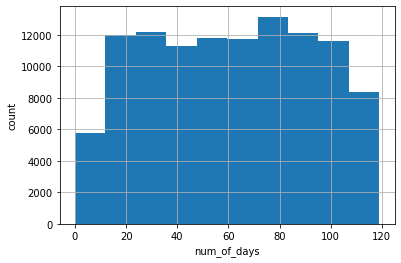

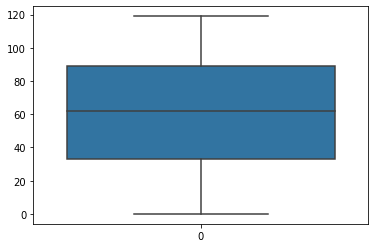

In [149]:
first_look(df,'num_of_days')

Изучим остальные числовые параметры:


Столбец age
Распределение признака:


count    110148.000000
mean         39.249410
std          11.518063
min          21.000000
25%          30.000000
50%          37.000000
75%          48.000000
max          72.000000
Name: age, dtype: float64

нижняя квартильная граница: 3.0
верхняя квартильная граница: 75.0
кол-во записей за нижней квартильной границей: 0
относительное кол-во записей за нижней квартильной границей: 0.0
кол-во записей за верхней квартильной границей: 0
относительное кол-во записей за верхней квартильной границей: 0.0


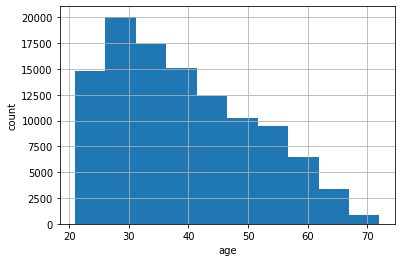

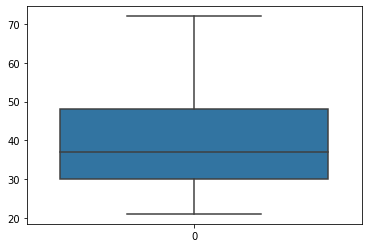

Столбец decline_app_cnt
Распределение признака:


count    110148.000000
mean          0.273205
std           0.799099
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          33.000000
Name: decline_app_cnt, dtype: float64

нижняя квартильная граница: 0.0
верхняя квартильная граница: 0.0
кол-во записей за нижней квартильной границей: 0
относительное кол-во записей за нижней квартильной границей: 0.0
кол-во записей за верхней квартильной границей: 18677
относительное кол-во записей за верхней квартильной границей: 0.17


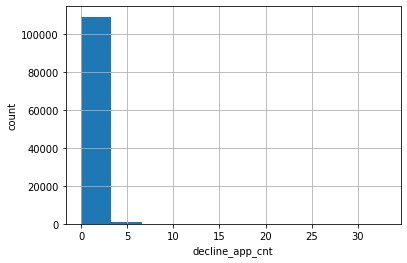

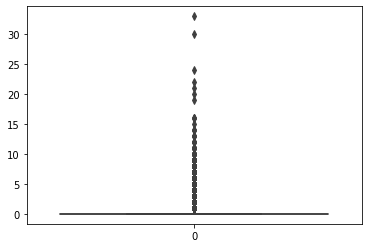

Столбец score_bki
Распределение признака:


count    110148.000000
mean         -1.904535
std           0.499397
min          -3.624586
25%          -2.260434
50%          -1.920823
75%          -1.567888
max           0.199773
Name: score_bki, dtype: float64

нижняя квартильная граница: -3.299251946250001
верхняя квартильная граница: -0.5290698762499992
кол-во записей за нижней квартильной границей: 82
относительное кол-во записей за нижней квартильной границей: 0.0
кол-во записей за верхней квартильной границей: 436
относительное кол-во записей за верхней квартильной границей: 0.0


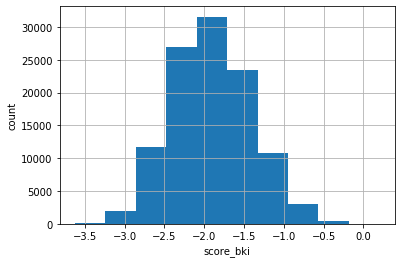

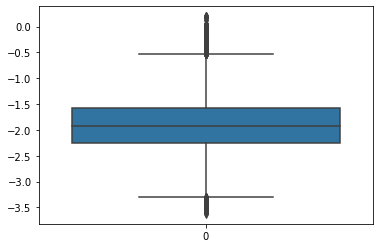

Столбец bki_request_cnt
Распределение признака:


count    110148.000000
mean          2.005002
std           2.266926
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          53.000000
Name: bki_request_cnt, dtype: float64

нижняя квартильная граница: -4.5
верхняя квартильная граница: 7.5
кол-во записей за нижней квартильной границей: 0
относительное кол-во записей за нижней квартильной границей: 0.0
кол-во записей за верхней квартильной границей: 2636
относительное кол-во записей за верхней квартильной границей: 0.02


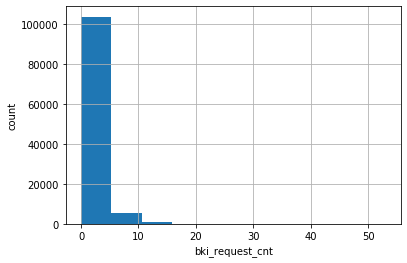

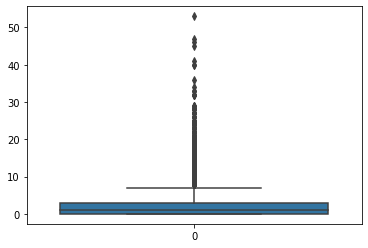

Столбец income
Распределение признака:


count     110148.000000
mean       41012.648537
std        45399.735051
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64

нижняя квартильная граница: -22000.0
верхняя квартильная граница: 90000.0
кол-во записей за нижней квартильной границей: 0
относительное кол-во записей за нижней квартильной границей: 0.0
кол-во записей за верхней квартильной границей: 7000
относительное кол-во записей за верхней квартильной границей: 0.06


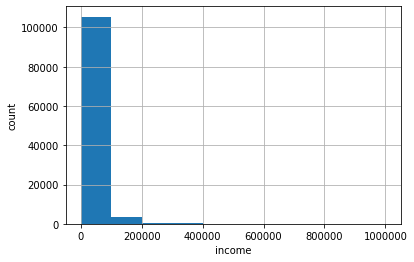

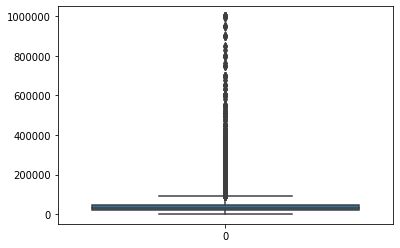

Столбец num_of_days
Распределение признака:


count    110148.000000
mean         60.971466
std          32.076078
min           0.000000
25%          33.000000
50%          62.000000
75%          89.000000
max         119.000000
Name: num_of_days, dtype: float64

нижняя квартильная граница: -51.0
верхняя квартильная граница: 173.0
кол-во записей за нижней квартильной границей: 0
относительное кол-во записей за нижней квартильной границей: 0.0
кол-во записей за верхней квартильной границей: 0
относительное кол-во записей за верхней квартильной границей: 0.0


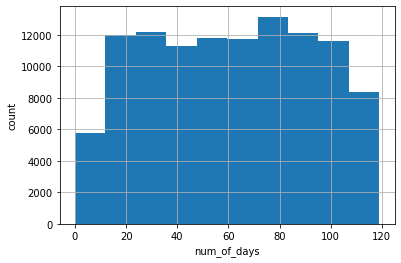

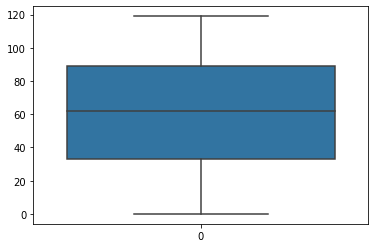

In [150]:
for i in num_cols:
    first_look(df,i)

как видно из исследования выше, самое неравномерное распределение значений у параметров:
1) decline_app_cnt;
2) bki_request_cnt;
3) income;

количество выбросов суммарно по параметрам составляет до 25% от данных. Слишком много данных удалять из выборки.
При этом практически незаметно относительное число выбросов для параметра score_bki:

нижняя квартильная граница: -3.2992846612499998
верхняя квартильная граница: -0.5286943912500002
кол-во записей за нижней квартильной границей: 81
относительное кол-во записей за нижней квартильной границей: 0.0
кол-во записей за верхней квартильной границей: 434
относительное кол-во записей за верхней квартильной границей: 0.0

=> можно, по-крайней мере, безболезненно почистить признак score_bki

In [392]:
df = df[(df['score_bki'] >= -3.30) & (df['score_bki'] <= -0.53)]

Столбец age
Распределение признака:


count    109631.000000
mean         39.247996
std          11.518253
min          21.000000
25%          30.000000
50%          37.000000
75%          48.000000
max          72.000000
Name: age, dtype: float64

нижняя квартильная граница: 3.0
верхняя квартильная граница: 75.0
кол-во записей за нижней квартильной границей: 0
относительное кол-во записей за нижней квартильной границей: 0.0
кол-во записей за верхней квартильной границей: 0
относительное кол-во записей за верхней квартильной границей: 0.0


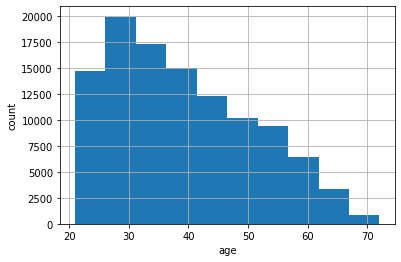

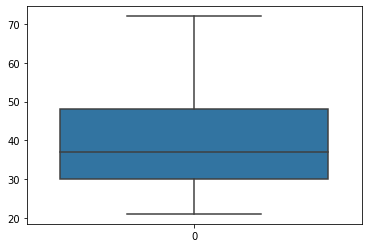

Столбец decline_app_cnt
Распределение признака:


count    109631.000000
mean          0.270909
std           0.793962
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          33.000000
Name: decline_app_cnt, dtype: float64

нижняя квартильная граница: 0.0
верхняя квартильная граница: 0.0
кол-во записей за нижней квартильной границей: 0
относительное кол-во записей за нижней квартильной границей: 0.0
кол-во записей за верхней квартильной границей: 18477
относительное кол-во записей за верхней квартильной границей: 0.17


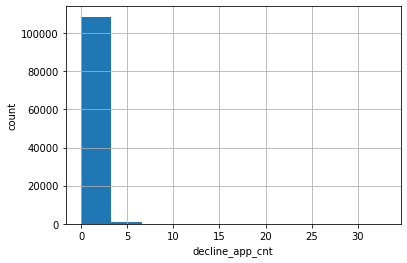

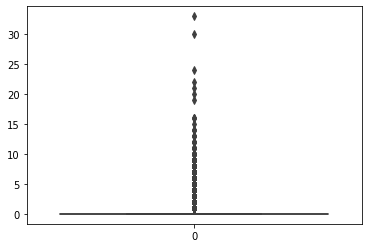

Столбец score_bki
Распределение признака:


count    109631.000000
mean         -1.909543
std           0.489298
min          -3.299885
25%          -2.261203
50%          -1.922200
75%          -1.572530
max          -0.530358
Name: score_bki, dtype: float64

нижняя квартильная граница: -3.294212035
верхняя квартильная граница: -0.5395211549999999
кол-во записей за нижней квартильной границей: 2
относительное кол-во записей за нижней квартильной границей: 0.0
кол-во записей за верхней квартильной границей: 26
относительное кол-во записей за верхней квартильной границей: 0.0


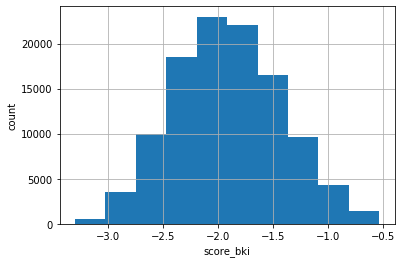

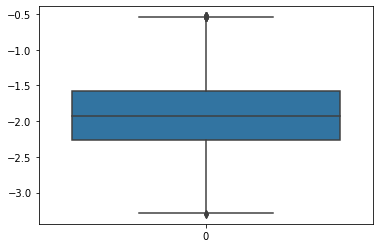

Столбец bki_request_cnt
Распределение признака:


count    109631.000000
mean          1.998486
std           2.245499
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          53.000000
Name: bki_request_cnt, dtype: float64

нижняя квартильная граница: -4.5
верхняя квартильная граница: 7.5
кол-во записей за нижней квартильной границей: 0
относительное кол-во записей за нижней квартильной границей: 0.0
кол-во записей за верхней квартильной границей: 2569
относительное кол-во записей за верхней квартильной границей: 0.02


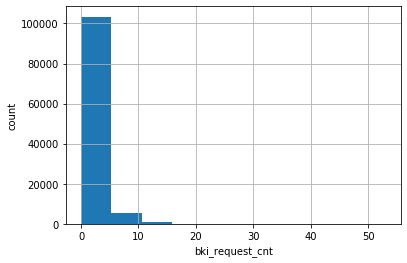

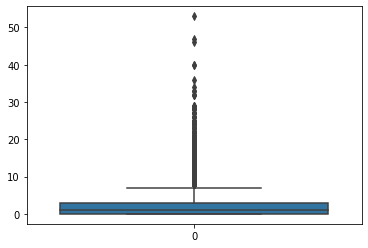

Столбец income
Распределение признака:


count     109631.000000
mean       40978.935347
std        45378.747672
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64

нижняя квартильная граница: -22000.0
верхняя квартильная граница: 90000.0
кол-во записей за нижней квартильной границей: 0
относительное кол-во записей за нижней квартильной границей: 0.0
кол-во записей за верхней квартильной границей: 6943
относительное кол-во записей за верхней квартильной границей: 0.06


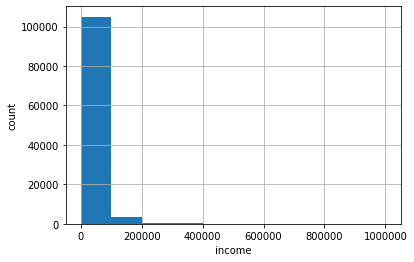

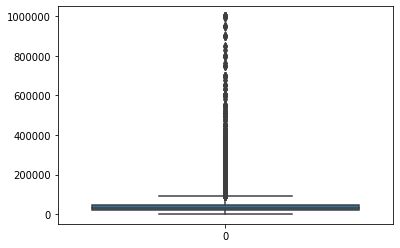

Столбец num_of_days
Распределение признака:


count    109631.000000
mean         60.999681
std          32.079615
min           0.000000
25%          33.000000
50%          62.000000
75%          89.000000
max         119.000000
Name: num_of_days, dtype: float64

нижняя квартильная граница: -51.0
верхняя квартильная граница: 173.0
кол-во записей за нижней квартильной границей: 0
относительное кол-во записей за нижней квартильной границей: 0.0
кол-во записей за верхней квартильной границей: 0
относительное кол-во записей за верхней квартильной границей: 0.0


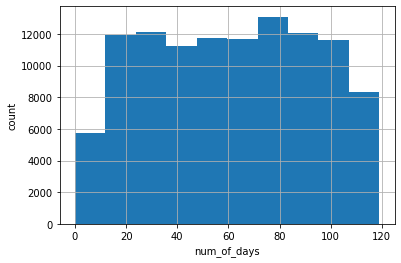

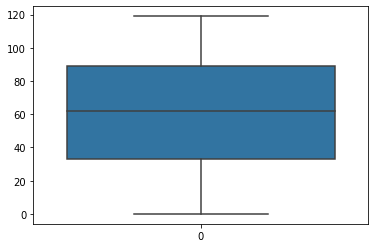

In [152]:
for i in num_cols:
    first_look(df,i)

Оценка корреляции

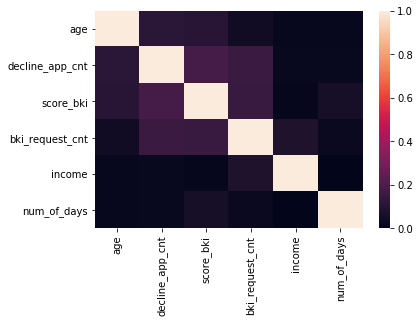

In [153]:
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1)

Нет сильно коррелированных между собой признаков, все оставляем.

Обработаем бинарные и категориальные признаки.
Предварительно, необходимо обработать education, т.к. у этого признака есть пропуски.

оценим, сколько пропусков в столбце.

In [154]:
df.education.isna().mean()*100

0.43418376189216557

как видно выше, в столбце education пропусков всего 0,43% => считаю целесообразным просто убрать пропуски, а не заполнять их

In [393]:
df.dropna(subset=['education'],inplace=True)

In [334]:
df

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,work_address,income,sna,first_time,foreign_passport,default,Train,num_of_days,month,weekend
0,25905,SCH,M,62,Y,Y,0,0,-2.008753,1,...,2,18000,4,1,N,0.0,1,31,2,1
1,63161,SCH,F,59,N,N,0,0,-1.532276,3,...,3,19000,4,1,N,0.0,1,70,3,0
2,25887,SCH,M,25,Y,N,2,0,-1.408142,1,...,2,30000,1,4,Y,0.0,1,31,2,1
3,16222,SCH,F,53,N,N,0,0,-2.057471,2,...,3,10000,1,3,N,0.0,1,22,1,0
4,101655,GRD,M,48,N,N,0,1,-1.244723,1,...,3,30000,1,4,Y,0.0,1,107,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,SCH,F,37,N,N,1,0,-1.744976,3,...,3,15000,4,1,N,NaN,0,89,3,0
110144,106254,GRD,F,64,Y,Y,0,0,-2.293781,3,...,2,200000,1,4,N,NaN,0,114,4,0
110145,81852,GRD,M,31,N,N,2,0,-0.940752,1,...,2,60000,4,2,N,NaN,0,88,3,1
110146,1971,UGR,F,27,N,N,1,0,-1.242392,2,...,3,30000,1,1,N,NaN,0,6,1,0


посмотрим на категориальные параметры

In [394]:
for i in cat_cols:
    display(df[i].value_counts())

SCH    57775
GRD    34570
UGR    14666
PGR     1857
ACD      287
Name: education, dtype: int64

50    40666
60    23821
40    17806
80    16924
70     9198
30      430
20      310
Name: region_rating, dtype: int64

2    58994
1    48306
3     1855
Name: home_address, dtype: int64

3    66447
2    30529
1    12179
Name: work_address, dtype: int64

1    70029
4    17322
2    15704
3     6100
Name: sna, dtype: int64

3    46207
4    27725
1    18128
2    17095
Name: first_time, dtype: int64

3    31306
2    26817
4    26098
1    24934
Name: month, dtype: int64

c учетом результатов исследования выше, считаю, что надо сделать dummy переменные из параметра education, остальные параметры оставить, как есть.

In [395]:
dummies = pd.get_dummies(df.education,prefix='education')

In [396]:
for i in dummies.columns:
    df[i] = dummies[i]
    #добавим соответствующее значение в bin_cols
    bin_cols.append(i)

In [397]:
df.drop(columns = ['education'],inplace = True)

In [398]:
#удалим 'education' из cat_cols
cat_cols.remove('education')
cat_cols

['region_rating', 'home_address', 'work_address', 'sna', 'first_time', 'month']

In [341]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109155 entries, 0 to 110147
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         109155 non-null  int64  
 1   sex               109155 non-null  object 
 2   age               109155 non-null  int64  
 3   car               109155 non-null  object 
 4   car_type          109155 non-null  object 
 5   decline_app_cnt   109155 non-null  int64  
 6   good_work         109155 non-null  int64  
 7   score_bki         109155 non-null  float64
 8   bki_request_cnt   109155 non-null  int64  
 9   region_rating     109155 non-null  int64  
 10  home_address      109155 non-null  int64  
 11  work_address      109155 non-null  int64  
 12  income            109155 non-null  int64  
 13  sna               109155 non-null  int64  
 14  first_time        109155 non-null  int64  
 15  foreign_passport  109155 non-null  object 
 16  default           73

Посмотрим на бинарные параметры

In [399]:
for i in bin_cols:
    display(df[i].value_counts())

F    61284
M    47871
Name: sex, dtype: int64

N    73661
Y    35494
Name: car, dtype: int64

N    88323
Y    20832
Name: car_type, dtype: int64

0    91085
1    18070
Name: good_work, dtype: int64

N    92907
Y    16248
Name: foreign_passport, dtype: int64

0    87000
1    22155
Name: weekend, dtype: int64

0    108868
1       287
Name: education_ACD, dtype: int64

0    74585
1    34570
Name: education_GRD, dtype: int64

0    107298
1      1857
Name: education_PGR, dtype: int64

1    57775
0    51380
Name: education_SCH, dtype: int64

0    94489
1    14666
Name: education_UGR, dtype: int64

как видно из исследования выше, параметры sex, car, car_type, foreign_passport надо оцифровать. Оцифруем по следующему принципу:
для sex - M = 1; F = 0. Для всех остальных - Y = 1, N = 0

In [400]:
ny = ['car','car_type','foreign_passport']

In [401]:
for i in ny:
    display(df[i].value_counts())

N    73661
Y    35494
Name: car, dtype: int64

N    88323
Y    20832
Name: car_type, dtype: int64

N    92907
Y    16248
Name: foreign_passport, dtype: int64

In [402]:
for i in ny:
    df[i][df[i] == 'Y'] = 1
    df[i][df[i] == 'N'] = 0
    df[i] = df[i].astype('int64')
    display(df[i].value_counts())

A:\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
A:\anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0    73661
1    35494
Name: car, dtype: int64

0    88323
1    20832
Name: car_type, dtype: int64

0    92907
1    16248
Name: foreign_passport, dtype: int64

In [403]:
df['sex'] = [1 if x == 'M' else 0 for x in df['sex']]
display(df['sex'].value_counts())
df['sex'] = df['sex'].astype('int64')

0    61284
1    47871
Name: sex, dtype: int64

In [404]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109155 entries, 0 to 110147
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         109155 non-null  int64  
 1   sex               109155 non-null  int64  
 2   age               109155 non-null  int64  
 3   car               109155 non-null  int64  
 4   car_type          109155 non-null  int64  
 5   decline_app_cnt   109155 non-null  int64  
 6   good_work         109155 non-null  int64  
 7   score_bki         109155 non-null  float64
 8   bki_request_cnt   109155 non-null  int64  
 9   region_rating     109155 non-null  int64  
 10  home_address      109155 non-null  int64  
 11  work_address      109155 non-null  int64  
 12  income            109155 non-null  int64  
 13  sna               109155 non-null  int64  
 14  first_time        109155 non-null  int64  
 15  foreign_passport  109155 non-null  int64  
 16  default           73

все параметры числовые, мы готовы к обучению

## Значимость непрерывных переменных по ANOVA F test

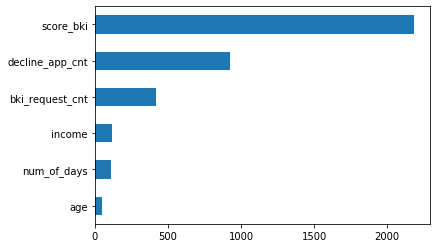

In [405]:
tr_df = df[df['Train']==1]
imp_num = pd.Series(f_classif(tr_df[num_cols], tr_df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

score_bki - с запасом самый значимый параметр, самый незначительный - age

## Значимость категориальных и бинарных параметров

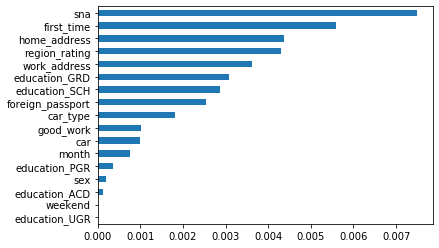

In [406]:
b_c_cols = bin_cols + cat_cols
imp_cat = pd.Series(mutual_info_classif(tr_df[b_c_cols], tr_df['default'], discrete_features =True), index = b_c_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

как видно из исследования выше, параметры weekend, education_UGR - вообще малозначимы, кандидаты на то, чтобы их убрать

# Обучение модели

Все данные практически готовы, осталось только стандартизировать численные параметры. Сделаем ниже.
Данные для обучения и валидации при этом будем стандартизировать отдельно

In [407]:
test_df = df[df['Train']==0]

In [408]:
X_train_num = StandardScaler().fit_transform(tr_df[num_cols].values)
X_test_num = StandardScaler().fit_transform(test_df[num_cols].values)

X_train = np.hstack([X_train_num, tr_df[b_c_cols].values])
X_test = np.hstack([X_test_num, test_df[b_c_cols].values])

y = tr_df['default'].values

Данные готовы. Перед тем, как приступать к обучению модели, посмотрим на целевой параметр.

0.0    0.873828
1.0    0.126172
Name: default, dtype: float64

отношение количества 0 в default к количеству 1 в default = 6.925677139761648


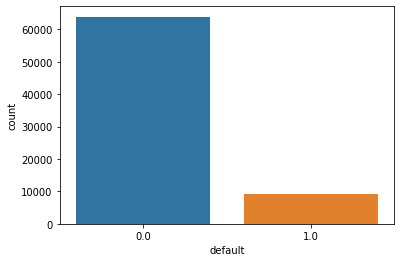

In [261]:
sns.countplot(tr_df['default']);
dflt = tr_df['default'].value_counts(normalize=True)
display(dflt)
print('отношение количества 0 в default к количеству 1 в default = {}'.format(dflt[0]/dflt[1]))

в целевой переменной очевиден значительный дисбаланс, согласно изученному в курсе:

### 1. Последствия дисбаланса данных
Что происходит при дисбалансе классов:

У алгоритма появляется склонность к более популярным классам/значениям.
Невозможность использования метрик, не учитывающих веса классов (базовая метрика accuracy, изученная выше, не может быть использована).

### 2. Решение проблемы
1) Изменить целевую метрику — в задачах классификации confusion matrix, precision, recall, F1-score, ROC-кривые будут намного корректнее описывать алгоритм, чем accuracy.
<br>2) Изменить выборку данных: 
<br>2.1) oversampling — увеличение кол-ва объектов классов-меньшинств; 
<br>2.2) undersampling — сокращение кол-ва объектов превалирующих классов.
<br>3) Добавить штраф в оптимизационный функционал, прямо пропорциональный кол-ву объектов каждого класса (веса классов).

## 1-й вариант модели. Работаем с данными такими, какие они есть.

In [409]:
# Разбиваем датасет на тренировочный и тестовый, выделив 20% данных на валидацию
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_train, y, test_size=0.2, random_state=RANDOM_SEED)

# Обучаем модель
model_1 = LogisticRegression(random_state=RANDOM_SEED)

model_1.fit(X_train_1, y_train_1)

# Предсказываем
y_pred_prob = model_1.predict_proba(X_test_1)[:,1]
y_pred = model_1.predict(X_test_1)

A:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Значение,Описание метрики
P,1906.000000,Дефолт
N,12725.000000,БЕЗ дефолта
TP,44.000000,Истинно дефолтные
TN,12680.000000,Истинно НЕ дефолтные
FP,45.000000,Ложно дефолтные
FN,1862.000000,Ложно НЕ дефолтные
Accuracy,0.869660,Accuracy=(TP+TN)/(P+N)
Precision,0.494382,Точность = TP/(TP+FP)
Recall,0.023085,Полнота = TP/P
F1-score,0.044110,Среднее гармоническое Precision и Recall


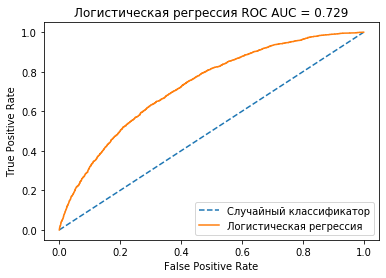

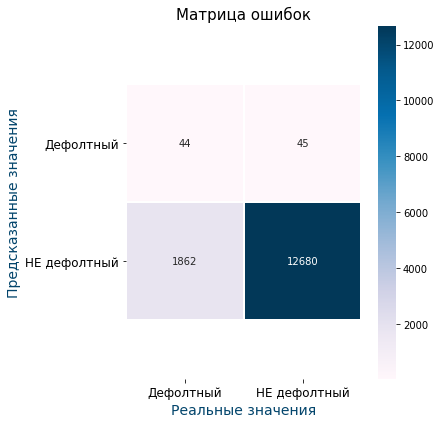

In [410]:
all_metrics(y_test_1, y_pred, y_pred_prob)
show_roc_curve(y_test_1, y_pred_prob)
show_confusion_matrix(y_test_1, y_pred)

ВЫВОДЫ: Модель плохо отработала. Несмотря на то, что ROC-AUC высокий (эта кривая плохо оценивает эффективность алгоритма на несбалансированных данных). Значение точности, полноты и f1 сигнализирует о том что что-то не в порядке. Построенная модель очень плохая: из матрицы ошибок видно, что мы почти не угадываем дефолтных клиентов (43 из 1906). Это показывает и метрика recall = 0.023085. 

## 2-й вариант модели. oversampling

oversampling сделаем самый простой - дублированием примеров меньшего класса. В нашем случае, класс с default = 1

In [411]:
max_size = tr_df['default'].value_counts().max()

In [412]:
lst = [tr_df]
for c_index, group in tr_df.groupby('default'):
    lst.append(group.sample(max_size-len(group),replace=True))
tr_df_new = pd.concat(lst)

In [413]:
tr_df_new.default.value_counts()

1.0    63924
0.0    63924
Name: default, dtype: int64

In [414]:
X_train_num_os = StandardScaler().fit_transform(tr_df_new[num_cols].values)
X_test_num_os = StandardScaler().fit_transform(test_df[num_cols].values)

X_train_os = np.hstack([X_train_num_os, tr_df_new[b_c_cols].values])
X_test_os = np.hstack([X_test_num_os, test_df[b_c_cols].values])

y_os = tr_df_new['default'].values

1.0    0.5
0.0    0.5
Name: default, dtype: float64

отношение количества 0 в default к количеству 1 в default = 1.0


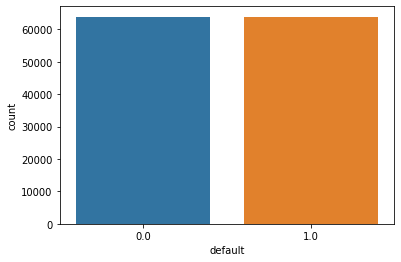

In [290]:
sns.countplot(tr_df_new['default']);
dflt = tr_df_new['default'].value_counts(normalize=True)
display(dflt)
print('отношение количества 0 в default к количеству 1 в default = {}'.format(dflt[0]/dflt[1]))

In [415]:
# Разбиваем датасет на тренировочный и тестовый, выделив 20% данных на валидацию
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_train_os, y_os, test_size=0.2, random_state=RANDOM_SEED)

# Обучаем модель
model_2 = LogisticRegression(random_state=RANDOM_SEED)

model_2.fit(X_train_2, y_train_2)

# Предсказываем
y_pred_prob = model_2.predict_proba(X_test_2)[:,1]
y_pred = model_2.predict(X_test_2)

A:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Значение,Описание метрики
P,12650.000000,Дефолт
N,12920.000000,БЕЗ дефолта
TP,8400.000000,Истинно дефолтные
TN,8540.000000,Истинно НЕ дефолтные
FP,4380.000000,Ложно дефолтные
FN,4250.000000,Ложно НЕ дефолтные
Accuracy,0.662495,Accuracy=(TP+TN)/(P+N)
Precision,0.657277,Точность = TP/(TP+FP)
Recall,0.664032,Полнота = TP/P
F1-score,0.660637,Среднее гармоническое Precision и Recall


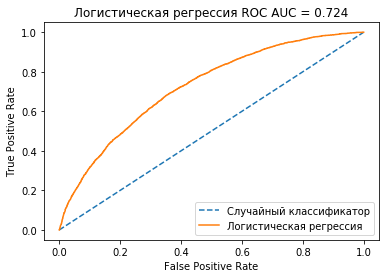

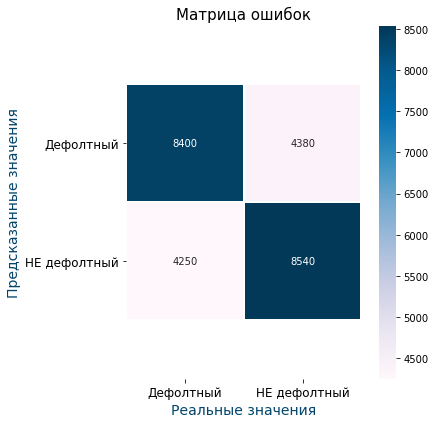

In [416]:
all_metrics(y_test_2, y_pred, y_pred_prob)
show_roc_curve(y_test_2, y_pred_prob)
show_confusion_matrix(y_test_2, y_pred)

ВЫВОДЫ: Модель значительно лучше отработала по сравнению с 1-м вариантом модели. ROC-AUC высокий, остался практически таким же, как и был: был 0.728934, стал 0.724065. 
<br>Precision вырос почти в 1,5 раза: был - 0.494382, стал - 0.657277. 
<br>Recall вырос в 33 раза где-то: был - 0.023085, стал - 0.664032   
<br>F1-score вырос в 16 раз где-то: был - 0.044110, стал - 0.660637
1-я модель значительно лучше предсказывала недефолты, но вообще не предсказывала дефолты => 2-я модель одинаково предсказывает и дефолты, и недефолты.

Отмечу, что я также нашел дополнительные данные, которыми можно было бы сделать oversampling нашего датасета, чтобы сбалансировать его: 
<br> 1 - https://www.kaggle.com/c/home-credit-default-risk/. Данные банка home credit
<br> - https://www.listendata.com/2019/08/datasets-for-credit-risk-modeling.html. Данные из ТАйваня.

Но, просмотрев данные, я увидел, что в 1-м случае (home credit) из 122 параметров, я могу использовать 3 (CODE_GENDER, FLAG_OWN_CAR, AMT_INCOME_TOTAL) + 1 - спорно (NAME_EDUCATION_TYPE) - мало данных, пришлось бы слишком много параметров выкинуть из исходного датасета.

2-й случай - аналогично, даже хуже: из 24 параметров, только 2 можно использовать (SEX, AGE) + 1 - спорно (EDUCATION)

Решил с этими внешними данными не работать.

## 3-й вариант модели. undersampling

In [417]:
#найдем количество дефолтных записей в датасете
n = tr_df[tr_df['default'] ==1]['sex'].count()

In [418]:
#подготовимся к объединению всех дефолтных записей с таким же количеством недефолтных
lst = [tr_df[tr_df['default'] ==1]]
#добавим к дефолтным записям столько же случайных недефолтных записей из датасета
lst.append(tr_df[tr_df['default'] ==0].sample(n))

tr_df_new = pd.concat(lst)

0.0    0.5
1.0    0.5
Name: default, dtype: float64

отношение количества 0 в default к количеству 1 в default = 1.0


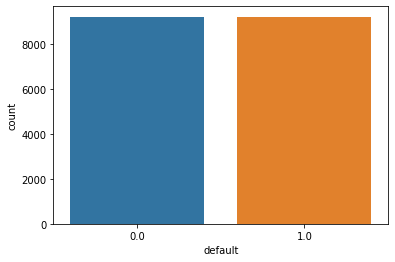

In [419]:
#проверим, как получилось
sns.countplot(tr_df_new['default']);
dflt = tr_df_new['default'].value_counts(normalize=True)
display(dflt)
print('отношение количества 0 в default к количеству 1 в default = {}'.format(dflt[0]/dflt[1]))

получилось сбалансировать

In [420]:
X_train_num_us = StandardScaler().fit_transform(tr_df_new[num_cols].values)
X_test_num_us = StandardScaler().fit_transform(test_df[num_cols].values)

X_train_us = np.hstack([X_train_num_us, tr_df_new[b_c_cols].values])
X_test_us = np.hstack([X_test_num_us, test_df[b_c_cols].values])

y_us = tr_df_new['default'].values

In [421]:
# Разбиваем датасет на тренировочный и тестовый, выделив 20% данных на валидацию
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_train_us, y_us, test_size=0.2, random_state=RANDOM_SEED)

# Обучаем модель
model_3 = LogisticRegression(random_state=RANDOM_SEED)

model_3.fit(X_train_3, y_train_3)

# Предсказываем
y_pred_prob = model_3.predict_proba(X_test_3)[:,1]
y_pred = model_3.predict(X_test_3)

A:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Значение,Описание метрики
P,1849.000000,Дефолт
N,1843.000000,БЕЗ дефолта
TP,1206.000000,Истинно дефолтные
TN,1215.000000,Истинно НЕ дефолтные
FP,628.000000,Ложно дефолтные
FN,643.000000,Ложно НЕ дефолтные
Accuracy,0.655742,Accuracy=(TP+TN)/(P+N)
Precision,0.657579,Точность = TP/(TP+FP)
Recall,0.652244,Полнота = TP/P
F1-score,0.654901,Среднее гармоническое Precision и Recall


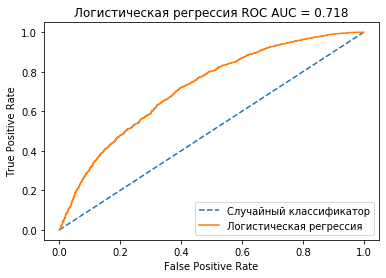

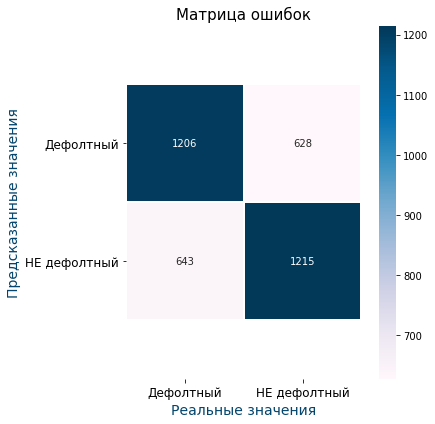

In [422]:
all_metrics(y_test_3, y_pred, y_pred_prob)
show_roc_curve(y_test_3, y_pred_prob)
show_confusion_matrix(y_test_3, y_pred)

ВЫВОДЫ: Модель значительно лучше отработала по сравнению с 1-м вариантом модели, результаты очень похожи на результаты 2-го варианта модели
<br>ROC-AUC высокий, остался практически таким же, как и был, стал даже чуть выше, чем для 1-й модели: 
1-я модель - 0.727372, 3-я - 0.727699. 
<br>Precision чуть вырос по сравнению с 2-й вариантом модели: 
2-я - 0.659274, 3-я - 0.667964. 
<br>Recall чуть уменьшился по сравнению с 2-й вариантом модели: 
2-я - 0.667352, 3-я - 0.649540.   
<br>F1-score чуть уменьшился по сравнению с 2-й вариантом модели: 
2-я - 0.663288, 3-я - 0.658624. 

undersampling сработал хорошо, практически также, как и самый простой oversampling. Возможно, если была бы возможность найти больше дефолтных данных, а не просто дублировать уже существующие, можно было бы еще улучшить показатели.

В текущих условиях, undersampling предпочтительнее использовать.

## 4-й вариант модели. Исследование влияния гиперпараметров на качество модели.

In [317]:
C = np.logspace(0, 4, 10)
iter_ = 50
epsilon_stop = 1e-3
 
hyperparameters = [
    {'penalty': ['l1'], 
     'C': C,
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'C': C,
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'C': C,
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
# указываем модель (в нашем случае лог регрессия), гиперпараметры
model = LogisticRegression(random_state=RANDOM_SEED)

# Обучаем модель
gridsearch = GridSearchCV(model, hyperparameters, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train_1, y_train_1)

A:\anaconda\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': array([1.00000000e+00, 2.7825...
                         {'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                          'class_weight': ['none', 'balanced'],
              

In [318]:
# Смотрим лучшие гиперпараметры
model_4 = gridsearch.best_estimator_

# Печатаем параметры
best_parameters = model_4.get_params()
print(f'Лучшие значения параметров:') 
for param_name in sorted(best_parameters.keys()):
        print(f'  {param_name} => {best_parameters[param_name]}')

# Предсказываем
y_pred_prob = model_4.predict_proba(X_test_1)[:,1]
y_pred = model_4.predict(X_test_1)

Лучшие значения параметров:
  C => 1.0
  class_weight => balanced
  dual => False
  fit_intercept => True
  intercept_scaling => 1
  l1_ratio => None
  max_iter => 50
  multi_class => auto
  n_jobs => None
  penalty => l2
  random_state => 42
  solver => saga
  tol => 0.001
  verbose => 0
  warm_start => False


,Значение,Описание метрики
P,1906.000000,Дефолт
N,12725.000000,БЕЗ дефолта
TP,1276.000000,Истинно дефолтные
TN,8478.000000,Истинно НЕ дефолтные
FP,4247.000000,Ложно дефолтные
FN,630.000000,Ложно НЕ дефолтные
Accuracy,0.666667,Accuracy=(TP+TN)/(P+N)
Precision,0.231034,Точность = TP/(TP+FP)
Recall,0.669465,Полнота = TP/P
F1-score,0.343519,Среднее гармоническое Precision и Recall


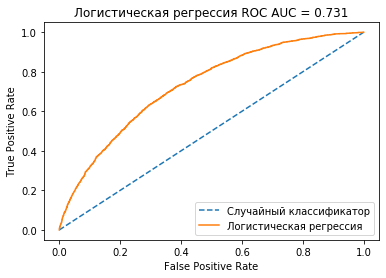

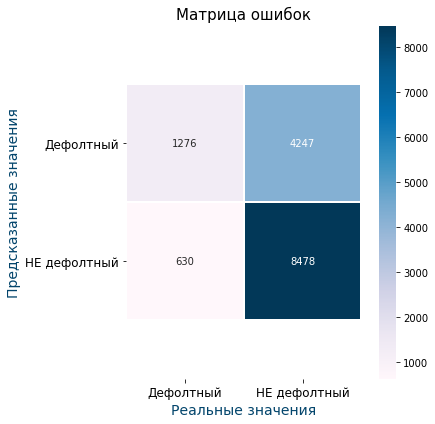

In [320]:
all_metrics(y_test_1, y_pred, y_pred_prob)
show_roc_curve(y_test_1, y_pred_prob)
show_confusion_matrix(y_test_1, y_pred)

ВЫВОДЫ: Модель значительно лучше отработала по сравнению с 1-м вариантом модели, но в общем, судя по метрикам, 3-й вариант модели отработал даже лучше:
<br>ROC-AUC сопоставим у 3-й и 4-й модели:
3-я модель = 0.727699, 4-я = 0.730800
<br> Precision гораздо (почти в 3 раза) лучше у 3-й модели:
3-я модель = 0.667964, 4-я = 0.231034
<br> Recall чуть лучше у 4-й модели:
3-я модель = 0.649540, 4-я = 0.669465
<br> F1-score гораздо лучше (почти в 2 раза) лучше у 3-й модели:
3-я модель = 0.658624, 4-я = 0.343519

Undersampling все еще - самый предпочтительный вариант.

## 5-й вариант модели. Оптимальные гиперпараметры и undersampling

In [323]:
print(datetime.now())
gridsearch.fit(X_train_3, y_train_3)
print(datetime.now())

2020-11-05 01:48:04.867791
2020-11-05 01:52:22.457118


A:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [325]:
# Смотрим лучшие гиперпараметры
model_5 = gridsearch.best_estimator_

# Печатаем параметры
best_parameters = model_5.get_params()
print(f'Лучшие значения параметров:') 
for param_name in sorted(best_parameters.keys()):
        print(f'  {param_name} => {best_parameters[param_name]}')

# Предсказываем
y_pred_prob = model_5.predict_proba(X_test_3)[:,1]
y_pred = model_5.predict(X_test_3)

Лучшие значения параметров:
  C => 21.544346900318832
  class_weight => none
  dual => False
  fit_intercept => True
  intercept_scaling => 1
  l1_ratio => None
  max_iter => 50
  multi_class => auto
  n_jobs => None
  penalty => l2
  random_state => 42
  solver => lbfgs
  tol => 0.001
  verbose => 0
  warm_start => False


,Значение,Описание метрики
P,1849.000000,Дефолт
N,1843.000000,БЕЗ дефолта
TP,1207.000000,Истинно дефолтные
TN,1251.000000,Истинно НЕ дефолтные
FP,592.000000,Ложно дефолтные
FN,642.000000,Ложно НЕ дефолтные
Accuracy,0.665764,Accuracy=(TP+TN)/(P+N)
Precision,0.670928,Точность = TP/(TP+FP)
Recall,0.652785,Полнота = TP/P
F1-score,0.661732,Среднее гармоническое Precision и Recall


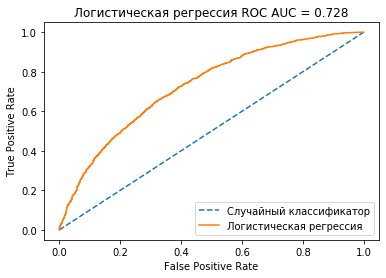

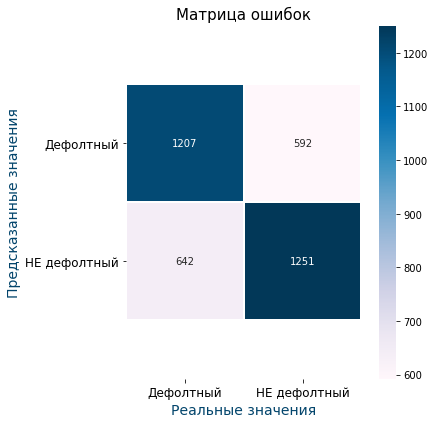

In [326]:
all_metrics(y_test_3, y_pred, y_pred_prob)
show_roc_curve(y_test_3, y_pred_prob)
show_confusion_matrix(y_test_3, y_pred)

ВЫВОДЫ: Модель показала очень маленький прирост по сравнению с моделью 3:
<br>ROC-AUC: 
3-я модель = 0.727699, 5-я = 0.727821
<br>Precision:
3-я модель = 0.667964, 5-я = 0.670928
<br>Recall:
3-я модель = 0.649540, 5-я = 0.652785
<br>F1-score: 
3-я модель = 0.658624, 5-я = 0.727821

Undersampling, с учетом трудоемкости, все еще - самый предпочтительный вариант.

# Общий вывод

Что удалось сделать:
<br>1) убрать пропуски из данных, т.к. их было очень мало (менее 0,5% от данных);
<br>2) убрать выбросы для параметра score_bki, т.к. их было очень мало (менее 0,01% от данных);
<br>3) избавиться от дисбаланса классов в моделях 2 (oversampling), 3(undersampling), 5(undersampling и использование оптимальных гиперпараметров);
<br>4) создать новые параметры num_of_days, month, weekend на основе параметра app_date, сам app_date удалить, как неподходящий для модели по типу данных;
<br>5) создать 5 моделей и выбрать из нее лучшую (модель 3, undersampling).


ЧТо можно было сделать еще:
<br>1) обогатить данные, поискав датасеты в Интернете;
<br>2) убрать не значимые признаки и проверить качество;
<br>3) сгенерировать новые признаки и посмотреть на улучшение;
<br>4) убрать выбросы и проверить качество.



